In [1]:
from collections import defaultdict
from pathlib import Path
import re
from subprocess import call
import time

from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import os

from scipy import interp
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.tree import export_graphviz
from tqdm.notebook import tqdm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

## Load and prep data

In [51]:
# read csv files of binned spectra an smaple labels
path="/Users/morris/Box/BG_Courses/CBIOS_Practicum"
os.chdir(path)
data = pd.read_csv(path+ '/output/otutable.csv', index_col=0)
responce_var = pd.read_csv(path+ '/output/task.csv', index_col=0)
phenotype_columns = {
    'Cancer_Microbiome': 'Var',
}

phenotype_titles = {
    'Cancer_Microbiome': 'Healthy vs. Tumor Classification',
}
phenotype = "Cancer_Microbiome"
plt_save_path = "/Users/morris/Box/BG_Courses/CBIOS_Practicum/output/figures"

In [52]:
status_col_name = 'Var'
case_label = "tumor"
control_label = "healthy"
comparison_lab_save = control_label + '_vs_' +case_label

In [4]:
# set figure resolution
mpl.rcParams['figure.dpi'] = 320

# Set a random seed
RANDOM_STATE = 1855

# Functions used in this analysis

## Splitting data and validating classifiers

In [5]:
def cross_validate_classifier(clf, X, y, cv=10):
    """Wrapper around the cross_validate function to conviently handle the returned data"""
    results = cross_validate(clf, X, y, cv=cv, return_estimator=True, n_jobs=-1)
    # Log relevant info
    print(f"Average training time = {results['fit_time'].mean():.2} seconds")
    print(f"Average test scoring time = {results['score_time'].mean():.2} seconds")
    print(f"Test Scores: {results['test_score']}")      
    scores = results['test_score']
    fitted_clfs = results['estimator']
    return scores, fitted_clfs

## Feature importance and selection

In [6]:
def select_features(importances, explained_proportion=0.9, plot_histogram=True):
    """
    Extract a subset of features explaining at least 'explained_proportion' of importance.
    Take the median value across CVs
    """
    # Separate importances out into columns
    median_importances = importances.unstack(level='CV').median(axis=1).sort_values(ascending=False)
    # Take all bins until the cumulative sum is > the desired value, otherwise take all
    selected = median_importances[median_importances.cumsum() <= explained_proportion]
    # Log
    print(f"Selected {len(selected):,} of {len(median_importances):,} features, adding up to {selected.sum():.3f} importance")
    # Return a list of bin names
    return list(np.sort(selected.index.values))

def collect_cv_gini_importance(X, fitted_clf_list):
    """
    Generate a dataframe of importance scores based on a list of fitted classifiers.
    """
    # Collect the importance scores into a dataframe
    dfs = []
    for idx, clf in enumerate(tqdm(fitted_clf_list)):
        df = pd.DataFrame({'Spectral_Bin': list(X.columns), 'CV': idx, 'Importance':clf.feature_importances_})
        dfs.append(df)
    df = pd.concat(dfs)
    
    # Index and Sort
    df = df.set_index(['Spectral_Bin', 'CV'])
    df.sort_values(by='Importance', ascending=False)
    return df

## Plotting

In [7]:
def plot_spectral_data(X, row_num):
    """
    Plot the spectral data for a given row in the feature df X
    """
    # Format data
    data = X.iloc[row_num]
    sample_name = data.name
    data = data.reset_index()
    data.columns=['bin', 'intensity']
    data['position'] = data['bin'].apply(lambda s: float(s[1:]))
    # Plot
    fig, ax = plt.subplots(1)
    ax.scatter(data['position'], data['intensity'], marker='.')
    ax.set_title(f"Data for sample '{sample_name}'")
    ax.set_ylim(0, data['intensity'].max()*1.1) 

    
def plot_importance(importances_df, ax=None, title='Feature Importances'):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1)
    for cv, subset in importances_df.groupby('CV'):
        y = subset['Importance'].sort_values(ascending=False).cumsum()
        x = range(len(y))
        ax.plot(x, y, label=f"Fold {cv}", alpha=0.9)
    ax.legend()
    ax.set_xlabel('Number of Spectral Bins', fontsize=12)
    ax.set_ylabel('Cumulative Importance', fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=12)

    
def plot_roc_cv(clf, X, y, cv=10, title=None, save=None):
    """
    Plot AUC using cross-validation
    See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
    """
    cv = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        viz = plot_roc_curve(clf, X.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=title)
    ax.legend(loc="lower right",prop={'size': 7})
    plt.savefig(save)
    plt.show()
    return ax


def confusion_matrix_analysis(clf, X, Y, cv=10, save=None):
    """
    Plot a confusion matrix for each cross-fold
    """
    # Rows are Non-normalized and normalized.  Columns are each CV fold
    fig, axes = plt.subplots(2, cv, figsize=(24, 10), sharex=True, sharey=True)
        
    # Create cv object
    cv_obj = StratifiedKFold(n_splits=cv)  # Note: this is the same cv approach used with 'cv=5' when scoring
    
    for i, (train, test) in enumerate(cv_obj.split(X, y)):
        clf.fit(X.iloc[train], y.iloc[train])
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        
        # Plot non-normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize=None,
                              cmap=plt.cm.Blues,
                              ax=axes[0, i],
                              xticks_rotation=45)
        # Plot normalized
        plot_confusion_matrix(clf, X_test, y_test,
                              display_labels=y_test.cat.categories,
                              normalize="true",
                              cmap=plt.cm.Blues,
                              ax=axes[1, i],
                              xticks_rotation=45)
    
    # Remove axes not in the subplot- these are the colorbars that clutter the image
    for a in fig.axes:
        if a not in axes:
            plt.delaxes(a)
    
    # Label the columns of plots
    for i in range(cv):
        axes[0, i].set_title(f"Fold {i}")
    plt.savefig(save)
    plt.tight_layout()

## 1.1 Prepare data for random forest model training

In [36]:
# transpose the otu table to place all the samples in the first column
dataT = data.T
dataM = dataT.merge(responce_var, left_index=True, right_index=True)
dataM.shape

(172, 910)

In [37]:
dataM.head()

,NR_147398.1_Anaerotruncus_rubiinfantis_strain_MT15_16S_ribosomal_RNA__partial_sequence,NR_041364.1_Prevotella_stercorea_strain_CB35_16S_ribosomal_RNA_gene__partial_sequence,NR_028961.1_Faecalibacterium_prausnitzii_strain_ATCC_27768_16S_ribosomal_RNA_gene__partial_sequence,NR_026204.1_{Clostridium}_viride_strain_T2-7_16S_ribosomal_RNA_gene__partial_sequence,NR_025796.1_{Clostridium}_jejuense_strain_HY-35-12_16S_ribosomal_RNA_gene__partial_sequence,NR_024906.1_Enterococcus_mundtii_strain_ATCC_43186_16S_ribosomal_RNA_gene__partial_sequence,NR_024815.1_Prevotella_shahii_strain_EHS11_16S_ribosomal_RNA_gene__partial_sequence,NR_024782.1_Diaphorobacter_nitroreducens_strain_NA10B_16S_ribosomal_RNA_gene__complete_sequence,NR_024661.1_Eubacterium_ruminantium_strain_GA195_16S_ribosomal_RNA_gene__partial_sequence,NR_024642.1_Lelliottia_amnigena_strain_JCM1237_16S_ribosomal_RNA_gene__partial_sequence,...,NR_147400.1_Clostridium_merdae_strain_Marseille-P2953_16S_ribosomal_RNA__partial_sequence,NR_147402.1_Sutturella_timonensis_strain_Marseille-P3282_16S_ribosomal_RNA__partial_sequence,NR_147403.1_Enorma_phocaeensis_strain_Marseille-P3242_16S_ribosomal_RNA__partial_sequence,NR_147406.1_Mordavella_massiliensis_strain_Marseille-P3246_16S_ribosomal_RNA__partial_sequence,NR_147405.1_Mailhella_massiliensis_strain_Marseille-P3199_16S_ribosomal_RNA__partial_sequence,NR_148330.1_Psychrobacter_fjordensis_strain_BSw21516B_16S_ribosomal_RNA__partial_sequence,NR_147740.1_Lactobacillus_insicii_strain_TMW_1.2011_16S_ribosomal_RNA__partial_sequence,NR_148261.1_Gordonibacter_faecihominis_strain_CAT-2_16S_ribosomal_RNA__partial_sequence,Var,ControlVar
82S3MNBY.518050,228,530,6,13,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Healthy,1457:82S3M
C0241.T.518067,2,348,83,2,2,0,0,0,1,0,...,0,1,0,0,0,0,0,0,Tumor,1457:C0241
OTGGZN5Y.518063,194,772,94,13,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,Healthy,1457:OTGGZ
OTGGZAZO.518108,19,1402,8,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Tumor,1457:OTGGZ
C0240.N.518020,0,596,720,3,0,4,0,1,0,0,...,0,0,0,1,0,0,0,0,Healthy,1457:C0240


In [38]:
X = dataM.drop(['Var', 'ControlVar'], axis=1)
X = X.fillna(0)
y = dataM['Var']

In [39]:
X.head()

,NR_147398.1_Anaerotruncus_rubiinfantis_strain_MT15_16S_ribosomal_RNA__partial_sequence,NR_041364.1_Prevotella_stercorea_strain_CB35_16S_ribosomal_RNA_gene__partial_sequence,NR_028961.1_Faecalibacterium_prausnitzii_strain_ATCC_27768_16S_ribosomal_RNA_gene__partial_sequence,NR_026204.1_{Clostridium}_viride_strain_T2-7_16S_ribosomal_RNA_gene__partial_sequence,NR_025796.1_{Clostridium}_jejuense_strain_HY-35-12_16S_ribosomal_RNA_gene__partial_sequence,NR_024906.1_Enterococcus_mundtii_strain_ATCC_43186_16S_ribosomal_RNA_gene__partial_sequence,NR_024815.1_Prevotella_shahii_strain_EHS11_16S_ribosomal_RNA_gene__partial_sequence,NR_024782.1_Diaphorobacter_nitroreducens_strain_NA10B_16S_ribosomal_RNA_gene__complete_sequence,NR_024661.1_Eubacterium_ruminantium_strain_GA195_16S_ribosomal_RNA_gene__partial_sequence,NR_024642.1_Lelliottia_amnigena_strain_JCM1237_16S_ribosomal_RNA_gene__partial_sequence,...,NR_147404.1_Massiliprevotella_massiliensis_strain_Marseille-P2439_16S_ribosomal_RNA__partial_sequence,NR_147401.1_Sutterella_massiliensis_strain_Marseille-P2435_16S_ribosomal_RNA__partial_sequence,NR_147400.1_Clostridium_merdae_strain_Marseille-P2953_16S_ribosomal_RNA__partial_sequence,NR_147402.1_Sutturella_timonensis_strain_Marseille-P3282_16S_ribosomal_RNA__partial_sequence,NR_147403.1_Enorma_phocaeensis_strain_Marseille-P3242_16S_ribosomal_RNA__partial_sequence,NR_147406.1_Mordavella_massiliensis_strain_Marseille-P3246_16S_ribosomal_RNA__partial_sequence,NR_147405.1_Mailhella_massiliensis_strain_Marseille-P3199_16S_ribosomal_RNA__partial_sequence,NR_148330.1_Psychrobacter_fjordensis_strain_BSw21516B_16S_ribosomal_RNA__partial_sequence,NR_147740.1_Lactobacillus_insicii_strain_TMW_1.2011_16S_ribosomal_RNA__partial_sequence,NR_148261.1_Gordonibacter_faecihominis_strain_CAT-2_16S_ribosomal_RNA__partial_sequence
82S3MNBY.518050,228,530,6,13,0,0,1,0,0,0,...,279,21,0,0,0,0,0,0,0,0
C0241.T.518067,2,348,83,2,2,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
OTGGZN5Y.518063,194,772,94,13,0,0,0,0,4,0,...,1,15,0,0,0,0,0,0,0,0
OTGGZAZO.518108,19,1402,8,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C0240.N.518020,0,596,720,3,0,4,0,1,0,0,...,99,172,0,0,0,1,0,0,0,0


In [40]:
# initialize RF classifier 
clf = RandomForestClassifier(n_estimators=10000, random_state=RANDOM_STATE, n_jobs=-1)

In [41]:
scores, clf_fitted = cross_validate_classifier(clf, X, y)

Average training time = 2.7e+01 seconds
Average test scoring time = 1.7 seconds
Test Scores: [0.83333333 0.66666667 0.52941176 0.70588235 0.76470588 0.76470588
 0.70588235 0.52941176 0.58823529 0.58823529]


In [42]:
# here the cross fold validation with an explicit 70-30 train-test split.
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=RANDOM_STATE)
cross_val_score(clf, X, y, cv=cv)

array([0.67307692, 0.76923077, 0.61538462, 0.67307692, 0.67307692,
       0.63461538, 0.71153846, 0.67307692, 0.71153846, 0.59615385])

## 1.4 Permutation test
These tests are done to discover which features are most important when classifiying 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=1855)

In [56]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10,
                                random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

/Users/morris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  """


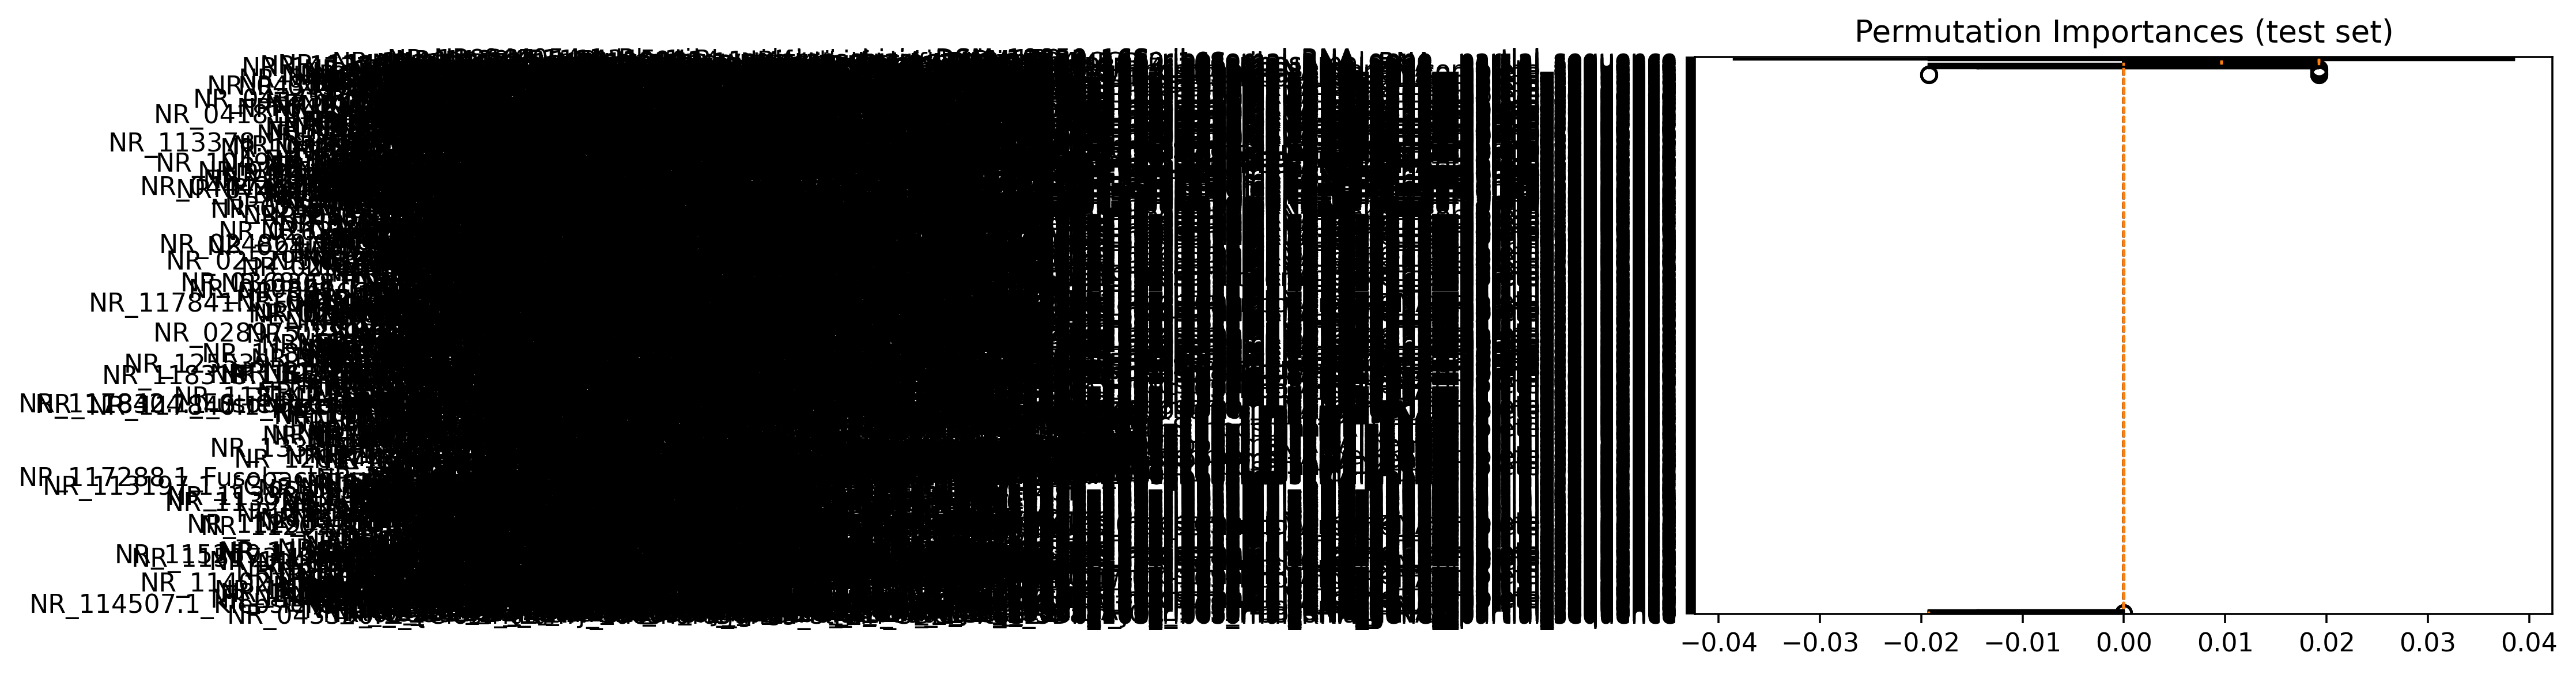

In [57]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## 1.4 model performance metrics
### ROC curves and AUC

In [49]:
auc_plot = plt_save_path + "/" +phenotype+ "_" +comparison_lab_save +"_RF_all_features_ROCAUC.png"
auc_plot

'/Users/morris/Box/BG_Courses/CBIOS_Practicum/output/figures/Cancer_Microbiome_healthy_vs_tumor_RF_all_features_ROCAUC.png'

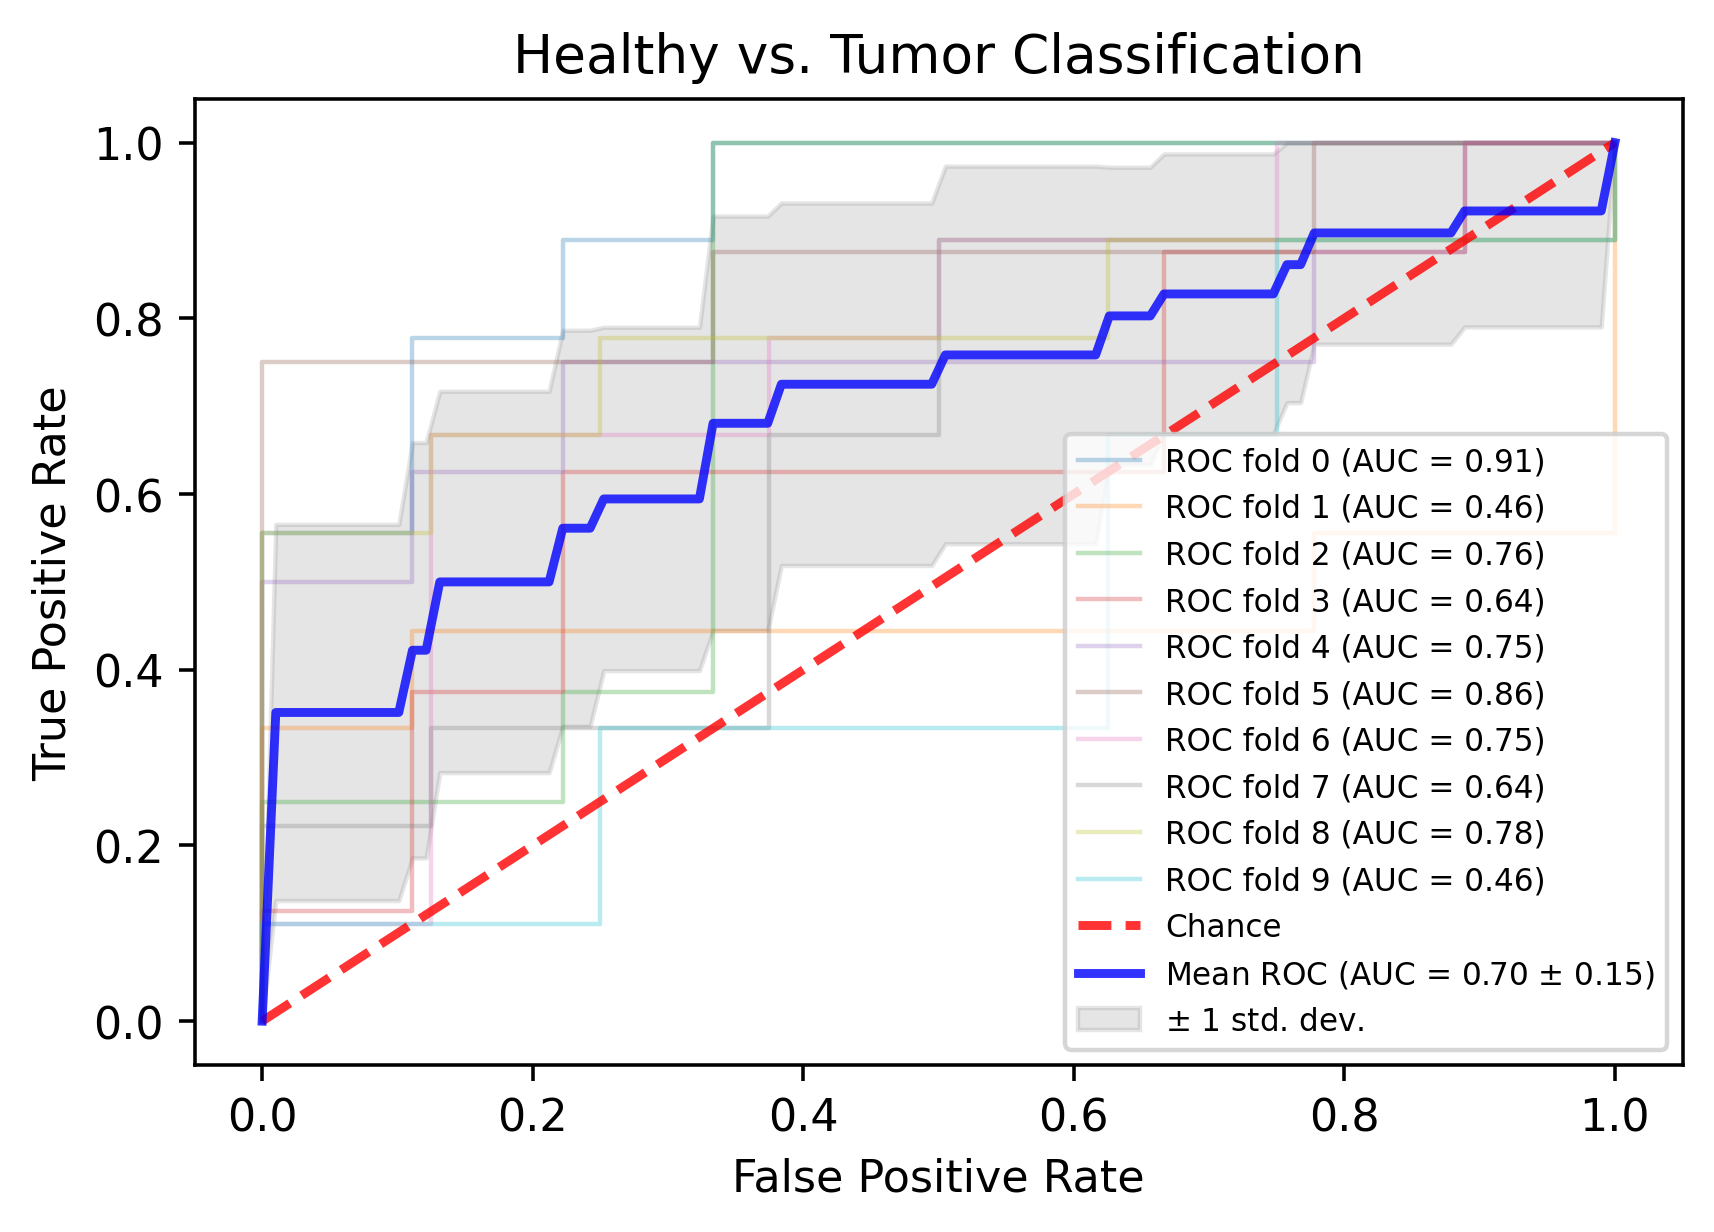

<AxesSubplot:title={'center':'Healthy vs. Tumor Classification'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
plot_roc_cv(clf, X, y, title=f"{phenotype_titles[phenotype]}", save=auc_plot)

### Visualize decision tree

In [62]:
tree_out = path + "/output/cancer_microbiome_tree.dot"
png_out = path + "/output/cancer_microbiome_tree.png"

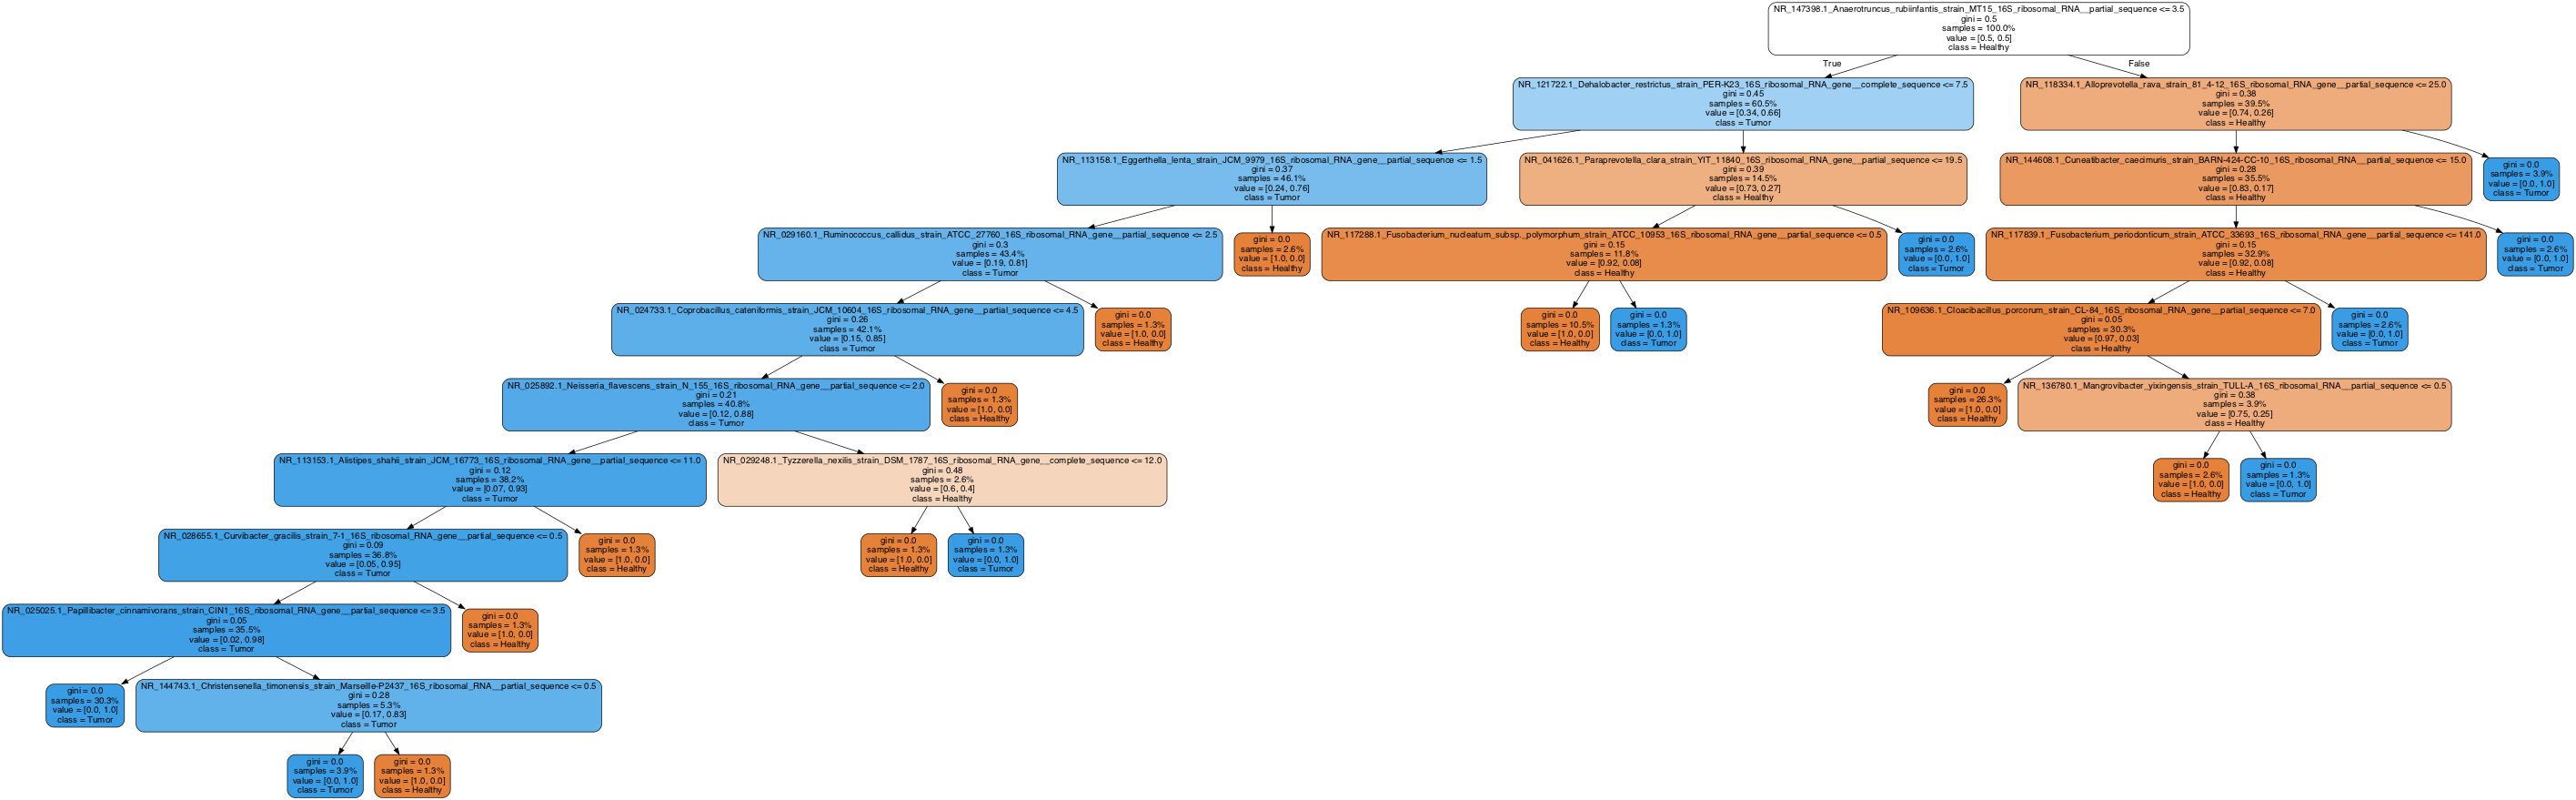

In [67]:
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
#import graphviz
# Export as dot file
export_graphviz(estimator, out_file=tree_out, 
                feature_names = list(X.columns.values),
                class_names = np.unique(np.asarray((y))),
                rounded = True,
                proportion = True,
                label = 'all',
                node_ids = False,
                precision = 2,
                filled = True,
                rotate =False,
                impurity=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', tree_out, '-o', png_out, '-Gdpi=50'])
plt.show()
# Display in jupyter notebook
from IPython.display import Image
Image(filename = png_out)